In [137]:
import os
import pandas as pd
from PyEMD import EMD
import numpy as np

labels = []
all_files = []
path = 'D:/vibration-inner'
labels_list = os.listdir(path)
print(labels_list)        
for i in labels_list:
    wavs_path = os.path.join(path,i)
    second_dirs = os.listdir(wavs_path)
    for csv in second_dirs:
        labels.append(i)
        csvFilePath = wavs_path+'/'+csv
        all_files.append(csvFilePath)
print(labels)
print(all_files)

['0', '1', '2']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

In [138]:
import torch
from torch.utils.data import Dataset

from vmdpy import VMD
import numpy as np


import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import os

path = 'D:/vibration'
class MyDataset(Dataset):
    def __init__(self):
        labels = []
        path = 'D:/vibration-inner'
        labels_list = os.listdir(path)
        for i in labels_list:
            wavs_path = os.path.join(path, i)
            second_dirs = os.listdir(wavs_path)
            for csv in second_dirs:
                labels.append(i)
        self.label = np.array(labels)
        # 创建 OneHotEncoder 对象
        self.encoder = OneHotEncoder(sparse_output=False)
        # 对标签进行独热编码
        encoded_labels = self.encoder.fit_transform([[label] for label in self.label])
        # 将独热编码结果保存为 Tensor
        self.encoded_labels_tensor = torch.tensor(encoded_labels, dtype=torch.float32)

    def __len__(self):
        return len(self.encoded_labels_tensor)

    def __getitem__(self,index):
        Fs=1024 # 采样频率
        N=1024 # 采样点数
        t=np.arange(1,N+1)/N
        fre_axis=np.linspace(0,Fs/2,int(N/2))
        label = self.encoded_labels_tensor[index]
        alpha=2000
        tau=0 # tau 噪声容限，即允许重构后的信号与原始信号有差别。
        K=3 # K 分解模态（IMF）个数
        DC=0 # DC 若为0则让第一个IMF为直流分量/趋势向量
        init=1 # init 指每个IMF的中心频率进行初始化。当初始化为1时，进行均匀初始化。
        tol=1e-7 # 控制误差大小常量，决定精度与迭代次数
        all_files = []
        path = 'D:/vibration'
        labels_list = os.listdir(path)
        for i in labels_list:
            wavs_path = os.path.join(path,i)
            second_dirs = os.listdir(wavs_path)
            for csv in second_dirs:
                csvFilePath = wavs_path+'/'+csv
                all_files.append(csvFilePath)
        csvpath = all_files[index]
        data = pd.read_csv(csvpath)
        signal = data['0']
        signal = np.array(signal)
        u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol) # 输出U是各个IMF分量，u_hat是各IMF的频谱，omega为各IMF的中心频率
        # 返回加载和预处理后的数据
        return torch.as_tensor(u,dtype=torch.float32), torch.as_tensor(label,dtype=torch.float)



In [139]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [140]:
dataset1 = MyDataset()
total_size = len(dataset1)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
print(total_size,train_size,val_size,test_size)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset1, [train_size, val_size, test_size])


6630 4641 994 995


In [141]:
data,label = dataset1[1]
print(data)
print(data.shape)
print(label)

tensor([[ 0.1595,  0.1199,  0.0444,  ...,  0.2170,  0.2807,  0.3164],
        [ 0.0085,  0.0015, -0.0104,  ..., -0.0866,  0.0686,  0.1826],
        [-0.1106,  0.1581,  0.0363,  ...,  0.0133,  0.1735, -0.1092]])
torch.Size([3, 1024])
tensor([1., 0., 0.])


In [142]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim,num_classes,num_layers, num_heads, dropout,linear_dim):
        super(TransformerClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(hidden_dim, input_dim)
        self.position_encoding = PositionalEncoding(hidden_dim)
        self.transformer_encoder = TransformerEncoder(hidden_dim, num_layers, num_heads, dropout)
        self.MLPclassifier = MLPClassifier(hidden_dim,linear_dim,num_classes)

    def forward(self, x):
        x = self.linear(x)
        encoded = self.position_encoding(x)
        transformed = self.transformer_encoder(encoded)
        output = self.MLPclassifier(transformed)
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_length=3):
        super(PositionalEncoding, self).__init__()

        position_encoding = torch.zeros(max_length, hidden_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))

        position_encoding[:, 0::2] = torch.sin(position * div_term)
        position_encoding[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('position_encoding', position_encoding.unsqueeze(0))

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.position_encoding[:x.size(0), :]
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, num_heads, dropout):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout):
        super(TransformerEncoderLayer, self).__init__()

        self.multihead_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attended = self.multihead_attention(x, x, x)[0]
        x = x + self.dropout(attended)
        x = self.layer_norm1(x)

        fed_forward = self.feed_forward(x)
        x = x + self.dropout(fed_forward)
        x = self.layer_norm2(x)

        return x

class MLPClassifier(nn.Module):
    def __init__(self,hidden_dim,linear_dim,num_classes):
        super(MLPClassifier, self).__init__()

        self.var = 3 * hidden_dim
        self.linear_1 = nn.Linear(self.var,linear_dim)
        self.linear_4 = nn.Linear(linear_dim,num_classes)

    
    def forward(self,x):
        x = x.reshape(-1,self.var)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_4(x)
        x = F.relu(x)
        x = F.softmax(x,dim=1)
        
        return x


In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 创建模型实例
model = TransformerClassifier(input_dim=1024,
                              hidden_dim=1024,
                              linear_dim=512,
                              num_classes=3,
                              num_layers=1,
                              num_heads=4,
                              dropout=0.1).cuda()
for param in model.parameters():
    print(type(param), param.size())
    
num_params = sum([param.nelement() for param in model.parameters()])
print(num_params)

<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([3072, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([3072])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([2048, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([2048])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 2048])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([512, 3072])
<class 'torch.nn.parameter.Parameter'> torch.Size([512])
<class 'torch.nn.parameter.Parameter'>

In [145]:
print(torch.cuda.is_available())
print(torch.version.cuda)

model = model.to('cuda')

for name, param in model.named_parameters():
    print(f"Parameter: {name}, Device: {param.device}")


True
12.1
Parameter: linear.weight, Device: cuda:0
Parameter: linear.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.in_proj_weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.in_proj_bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.out_proj.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.out_proj.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.0.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.0.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.2.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.2.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.layer_norm1.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.layer_norm1.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.layer_norm2.weight, Device: cuda:0
Parameter: transf

In [146]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        train_total += labels.size(0)
        
        for i in range(labels.size(0)):
            onehotpredicted = torch.zeros(3)
            index = predicted[i]
            onehotpredicted[index]=1.0
            onehotpredicted = onehotpredicted.to('cuda')
            if torch.equal(onehotpredicted,labels[i]):
                train_correct += 1
            

    train_loss /= len(train_dataloader)
    train_acc = train_correct / train_total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            for i in range(labels.size(0)):
                onehotpredicted = torch.zeros(3)
                index = predicted[i]
                onehotpredicted[index]=1.0
                onehotpredicted = onehotpredicted.to('cuda')
                if torch.equal(onehotpredicted,labels[i]):
                    correct += 1

    val_loss /= len(val_dataloader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 146/146 [01:26<00:00,  1.69it/s]


Epoch 1/20, Train Loss: 1.0207, Train Acc: 0.5117, Val Loss: 0.9933, Val Acc: 0.5332


100%|██████████| 146/146 [01:46<00:00,  1.37it/s]


Epoch 2/20, Train Loss: 0.9754, Train Acc: 0.5553, Val Loss: 0.9570, Val Acc: 0.5594


100%|██████████| 146/146 [00:57<00:00,  2.55it/s]


Epoch 3/20, Train Loss: 0.9471, Train Acc: 0.5992, Val Loss: 0.9238, Val Acc: 0.6187


100%|██████████| 146/146 [00:55<00:00,  2.61it/s]


Epoch 4/20, Train Loss: 0.8802, Train Acc: 0.6761, Val Loss: 0.8337, Val Acc: 0.7213


100%|██████████| 146/146 [00:58<00:00,  2.47it/s]


Epoch 5/20, Train Loss: 0.8098, Train Acc: 0.7399, Val Loss: 0.8210, Val Acc: 0.7233


100%|██████████| 146/146 [00:59<00:00,  2.47it/s]


Epoch 6/20, Train Loss: 0.8054, Train Acc: 0.7434, Val Loss: 0.8054, Val Acc: 0.7525


100%|██████████| 146/146 [00:59<00:00,  2.47it/s]


Epoch 7/20, Train Loss: 0.7728, Train Acc: 0.7753, Val Loss: 0.7930, Val Acc: 0.7565


100%|██████████| 146/146 [01:02<00:00,  2.33it/s]


Epoch 8/20, Train Loss: 0.7671, Train Acc: 0.7873, Val Loss: 0.7814, Val Acc: 0.7575


100%|██████████| 146/146 [01:01<00:00,  2.37it/s]


Epoch 9/20, Train Loss: 0.7481, Train Acc: 0.8024, Val Loss: 0.7575, Val Acc: 0.7978


100%|██████████| 146/146 [00:58<00:00,  2.49it/s]


Epoch 10/20, Train Loss: 0.7136, Train Acc: 0.8533, Val Loss: 0.7617, Val Acc: 0.7907


100%|██████████| 146/146 [00:57<00:00,  2.52it/s]


Epoch 11/20, Train Loss: 0.6884, Train Acc: 0.9084, Val Loss: 0.7153, Val Acc: 0.8843


100%|██████████| 146/146 [00:58<00:00,  2.49it/s]


Epoch 12/20, Train Loss: 0.6727, Train Acc: 0.9438, Val Loss: 0.7092, Val Acc: 0.8883


100%|██████████| 146/146 [00:58<00:00,  2.49it/s]


Epoch 13/20, Train Loss: 0.6665, Train Acc: 0.9616, Val Loss: 0.6944, Val Acc: 0.9085


100%|██████████| 146/146 [00:57<00:00,  2.56it/s]


Epoch 14/20, Train Loss: 0.6606, Train Acc: 0.9765, Val Loss: 0.6929, Val Acc: 0.9286


100%|██████████| 146/146 [00:56<00:00,  2.57it/s]


Epoch 15/20, Train Loss: 0.6589, Train Acc: 0.9819, Val Loss: 0.6933, Val Acc: 0.9286


100%|██████████| 146/146 [00:58<00:00,  2.50it/s]


Epoch 16/20, Train Loss: 0.6583, Train Acc: 0.9832, Val Loss: 0.6911, Val Acc: 0.9356


100%|██████████| 146/146 [00:59<00:00,  2.47it/s]


Epoch 17/20, Train Loss: 0.6567, Train Acc: 0.9879, Val Loss: 0.6958, Val Acc: 0.9437


100%|██████████| 146/146 [00:58<00:00,  2.50it/s]


Epoch 18/20, Train Loss: 0.6597, Train Acc: 0.9886, Val Loss: 0.6910, Val Acc: 0.9276


100%|██████████| 146/146 [00:59<00:00,  2.46it/s]


Epoch 19/20, Train Loss: 0.6562, Train Acc: 0.9890, Val Loss: 0.6868, Val Acc: 0.9517


100%|██████████| 146/146 [00:59<00:00,  2.46it/s]


Epoch 20/20, Train Loss: 0.6593, Train Acc: 0.9853, Val Loss: 0.7194, Val Acc: 0.9306


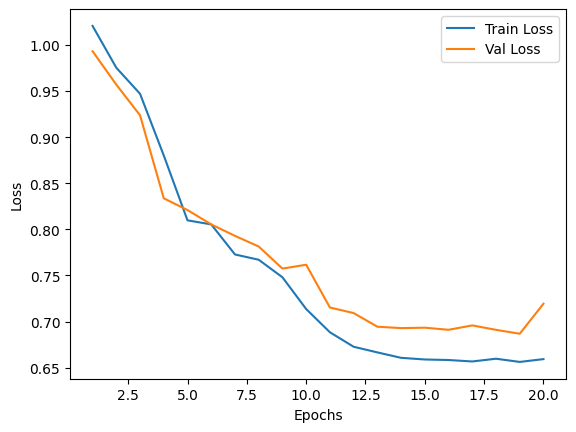

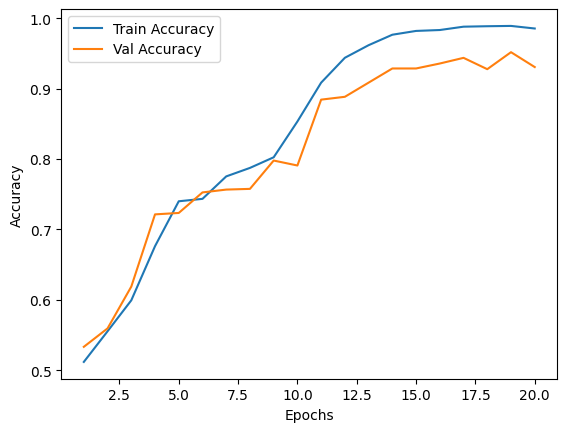

In [147]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [152]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)

        for i in range(labels.size(0)):
            onehotpredicted = torch.zeros(3)
            index = predicted[i]
            onehotpredicted[index]=1.0
            onehotpredicted = onehotpredicted.to('cuda')
            if torch.equal(onehotpredicted,labels[i]):
                correct += 1
# 输出测试集上的损失和准确率
print(f"Test Loss: {test_loss/len(test_dataloader)}, Test Accuracy: {(correct/total)*100}%")
print(correct)
print(total)

100%|██████████| 32/32 [00:12<00:00,  2.53it/s]

Test Loss: 0.6962152887135744, Test Accuracy: 93.36683417085428%
929
995


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, labels_name, title="Confusion Matrix",  is_norm=True,  colorbar=True, cmap=plt.cm.Blues):
    if is_norm==True:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)  # 横轴归一化并保留2位小数

    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # 在特定的窗口上显示图像
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.annotate(cm[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center') # 默认所有值均为黑色
            # plt.annotate(cm[j, i], xy=(i, j), horizontalalignment='center', color="white" if i==j else "black", verticalalignment='center') # 将对角线值设为白色
    if colorbar:
        plt.colorbar() # 创建颜色条

    num_local = np.array(range(len(labels_name)))
    plt.xticks(num_local, labels_name)  # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)  # 将标签印在y轴坐标上
    plt.title(title)  # 图像标题
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show() # plt.show()在plt.savefig()之后
    plt.close()


In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_preds = torch.tensor([]).cuda()
all_labels = torch.tensor([]).cuda()

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)

        for i in range(labels.size(0)):
            onehotpredicted = torch.zeros(3)
            index = predicted[i]
            onehotpredicted[index]=1.0
            onehotpredicted = onehotpredicted.to('cuda')
            all_preds = torch.cat((all_preds,torch.tensor([index]).cuda()),dim=0)
            real_labels = torch.argmax(labels,dim=1)
            all_labels = torch.cat((all_labels,torch.tensor([real_labels[i]]).cuda()),dim=0)
            if torch.equal(onehotpredicted,labels[i]):
                correct += 1
# 输出测试集上的损失和准确率
print(f"Test Loss: {test_loss/len(test_dataloader)}, Test Accuracy: {(correct/total)*100}%")
print(correct)
print(total)


NameError: name 'model' is not defined

In [5]:
all_labels,all_preds = all_labels.cpu(),all_preds.cpu()

conf_matrix = confusion_matrix(all_labels, all_preds)

plot_confusion_matrix(conf_matrix,['Outer1', 'Outer2', 'Outer3'],title='cm',is_norm=False)
plot_confusion_matrix(conf_matrix,['Outer1', 'Outer2', 'Outer3'],title='cm',is_norm=True)

NameError: name 'all_labels' is not defined